# Section 0 : Introduction

In this section, I set the stage for my first public analysis on Kaggle.  This introductory project mostly serves as a way to get my feet weet with the syntax of data science in Python, after having primarily used a combination of SAS, R and MATLAB in my prior professional and academic positions.

Just to quickly note, this notebook is based on information I've gathered from various sources but the overall analysis plotline mimics this Kaggle post (https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook).

With that out of the way, below you will find loose interpretations of various data science workflow objects and methods, along with Python implementations of each.  Topics included are imputation, outlier detection (categorical/numerical), imputation, feature engineering, one-hot encoding, regression, support vector machines, decision trees, random forests, adaptive boosting, gradient boosting, neural networks, and linear discriminant analysis.

# Section 1 : Libraries & Datasets

In [89]:
# Importing packages
import plotly.plotly as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

path = "E:/Dropbox/Kaggle/Titanic"
os.chdir(path)

train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

# Combine train and test datasets to include
# full universe for future feature engineering purposes
full = pd.concat([train,test])

# A list of IDs to include in comparison dataset
IDtest = test["PassengerId"]

In [63]:
# Compare columns to ensure training dataset is not missing variables 
full.columns.get_values()

# Empty so we're good
np.setdiff1d(full.columns.get_values(), train.columns.get_values())

array([], dtype=object)

In [64]:
# Let's take a closer look at our training dataset in its rawest form
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
# Count of missing values
full.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

# Impute missing values

In [66]:
full['Age'].loc[full['Age'].isnull()]=-1
full['Cabin'].loc[full['Cabin'].isnull()]='Unknown'
full['Embarked'].loc[full['Embarked'].isnull()]='U'
full['Fare'].loc[full['Fare'].isnull()]=-1

e:\programs\python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [67]:
train_len = len(train)
train = full[:train_len]
test = full[train_len:]

# Feature Engineering : Numerical Outlier Removal

In [68]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [69]:
train.loc[Outliers_to_drop] # Show the outliers rows

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
27,19.0,C23 C25 C27,S,263.00,"Fortune, Mr. Charles Alexander",2,28,1,male,3,0.0,19950
88,23.0,C23 C25 C27,S,263.00,"Fortune, Miss. Mabel Helen",2,89,1,female,3,1.0,19950
159,-1.0,Unknown,S,69.55,"Sage, Master. Thomas Henry",2,160,3,male,8,0.0,CA. 2343
180,-1.0,Unknown,S,69.55,"Sage, Miss. Constance Gladys",2,181,3,female,8,0.0,CA. 2343
201,-1.0,Unknown,S,69.55,"Sage, Mr. Frederick",2,202,3,male,8,0.0,CA. 2343
324,-1.0,Unknown,S,69.55,"Sage, Mr. George John Jr",2,325,3,male,8,0.0,CA. 2343
341,24.0,C23 C25 C27,S,263.00,"Fortune, Miss. Alice Elizabeth",2,342,1,female,3,1.0,19950
792,-1.0,Unknown,S,69.55,"Sage, Miss. Stella Anna",2,793,3,female,8,0.0,CA. 2343
846,-1.0,Unknown,S,69.55,"Sage, Mr. Douglas Bullen",2,847,3,male,8,0.0,CA. 2343
863,-1.0,Unknown,S,69.55,"Sage, Miss. Dorothy Edith ""Dolly""",2,864,3,female,8,0.0,CA. 2343


In [70]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [71]:
train_len = len(train)
full =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [72]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,Unknown,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,Unknown,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,Unknown,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [74]:
# Infos
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
Age            881 non-null float64
Cabin          881 non-null object
Embarked       881 non-null object
Fare           881 non-null float64
Name           881 non-null object
Parch          881 non-null int64
PassengerId    881 non-null int64
Pclass         881 non-null int64
Sex            881 non-null object
SibSp          881 non-null int64
Survived       881 non-null float64
Ticket         881 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 82.7+ KB


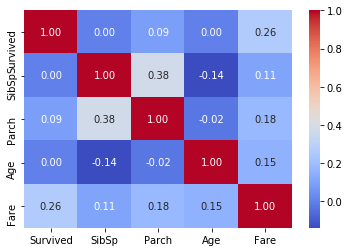

In [75]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

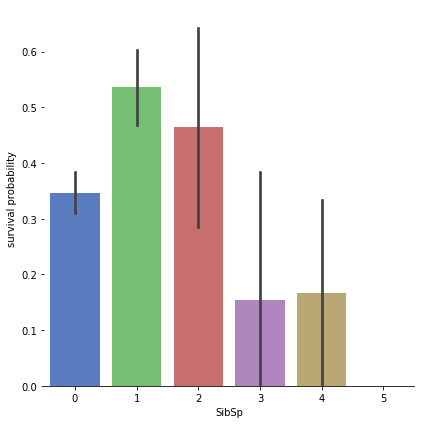

In [76]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

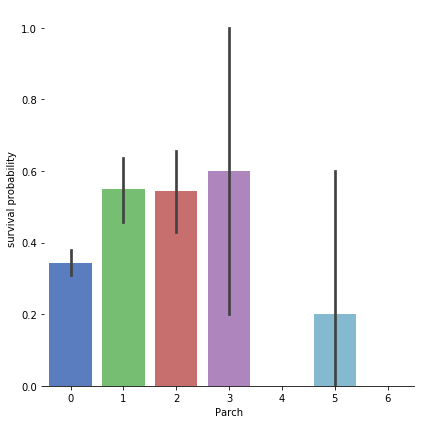

In [77]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

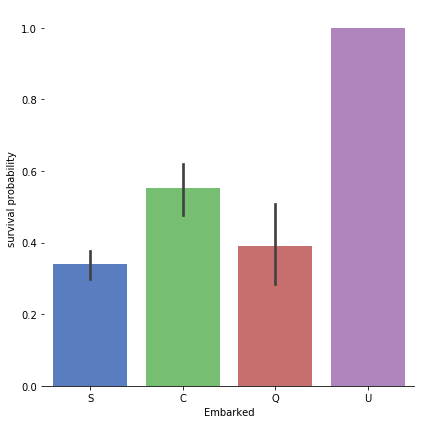

In [78]:
# Explore Embarked feature vs Survived
g  = sns.factorplot(x="Embarked",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Those whose departure location was missing have 100 percent survival.

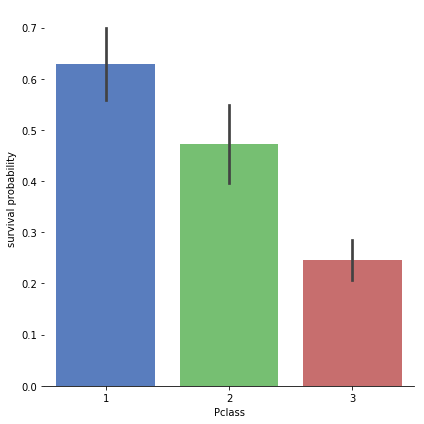

In [79]:
# Explore Pclass feature vs Survived
g  = sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

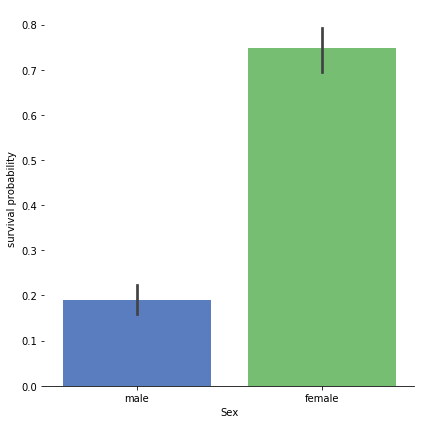

In [82]:
# Explore Sex feature vs Survived
g  = sns.factorplot(x="Sex",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

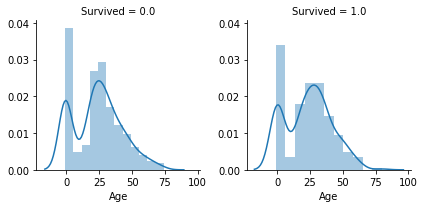

In [80]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

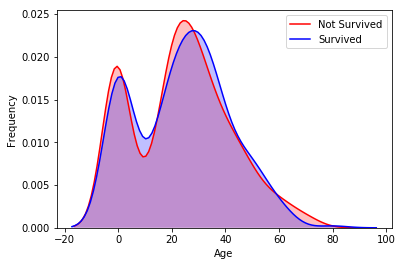

In [83]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

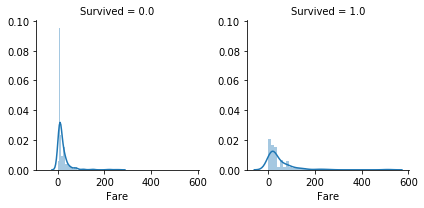

In [81]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Fare")

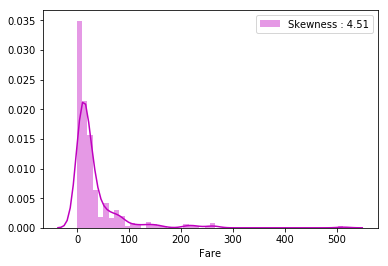

In [85]:
# Explore Fare distribution 
g = sns.distplot(full["Fare"], color="m", label="Skewness : %.2f"%(full["Fare"].skew()))
g = g.legend(loc="best")

In [86]:
full["Fare"] = full["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

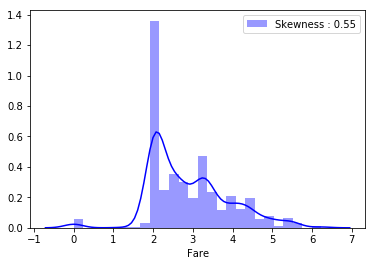

In [88]:
g = sns.distplot(full["Fare"], color="b", label="Skewness : %.2f"%(full["Fare"].skew()))
g = g.legend(loc="best")